<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative04102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações 

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
print(tf.__version__)

# Instalar Tensorflow
#!pip install tensorflow==2.6.0

# Instalar Keras
!pip install keras --upgrade

2.6.0


In [ ]:
# Caso precise, remover os diretorios

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
!rm -rf geological_similarity

# **Coleta de dados do Kaglle**

In [2]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# **###  Download dos dados / descompactando os dados**

In [3]:
#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity    

 74% 25.0M/33.6M [00:00<00:00, 105MB/s] 
100% 33.6M/33.6M [00:00<00:00, 132MB/s]


# ** Criação da estrutura e leitura de diretórios **

# **Criação da estrutura e leitura de diretórios - Outra forma**

In [4]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


5000
5000
4998
5000
5000
5000


In [5]:
andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']


for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)


In [6]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/schist/44HSM.jpg,schist
1,geological_similarity/quartzite/5F0E0.jpg,quartzite
2,geological_similarity/marble/PFKYV.jpg,marble
3,geological_similarity/rhyolite/IP1H6.jpg,rhyolite
4,geological_similarity/marble/XZO88.jpg,marble
...,...,...
29993,geological_similarity/gneiss/W25V0.jpg,gneiss
29994,geological_similarity/gneiss/IU09P.jpg,gneiss
29995,geological_similarity/andesite/T3V5A.jpg,andesite
29996,geological_similarity/marble/LFSHC.jpg,marble


# **Separação das amostras**

In [ ]:
#X = data_df.drop(columns='label')
#y = data_df.label

In [7]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (32, 32))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


In [8]:
# converter os dados e rótulos em matrizes NumPy enquanto dimensiona o pixel, intensidades na faixa [0, 255]

dados = np.array(dados) / 255.0
labels = np.array(labels)
labels

array(['schist', 'quartzite', 'marble', ..., 'andesite', 'marble',
       'quartzite'], dtype='<U9')

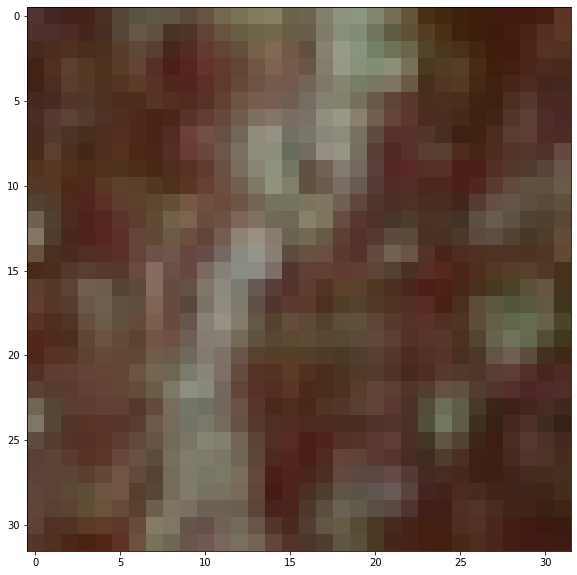

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(dados[labels=='marble'][5])
plt.show()

In [10]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)
labels

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [11]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels, stratify=labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [12]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 32, 32, 3)
(17998, 6)
(6000, 32, 32, 3)
(6000, 6)
(6000, 32, 32, 3)
(6000, 6)


In [13]:
#X_train = X_train.reshape(X_train.shape[0], 28, 28, 3).astype('float32')
#X_val = X_val.reshape(X_val.shape[0], 28, 28, 3).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 3).astype('float32')

X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [14]:
y_test

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

#  Conhecendo os dados de imagem

In [15]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

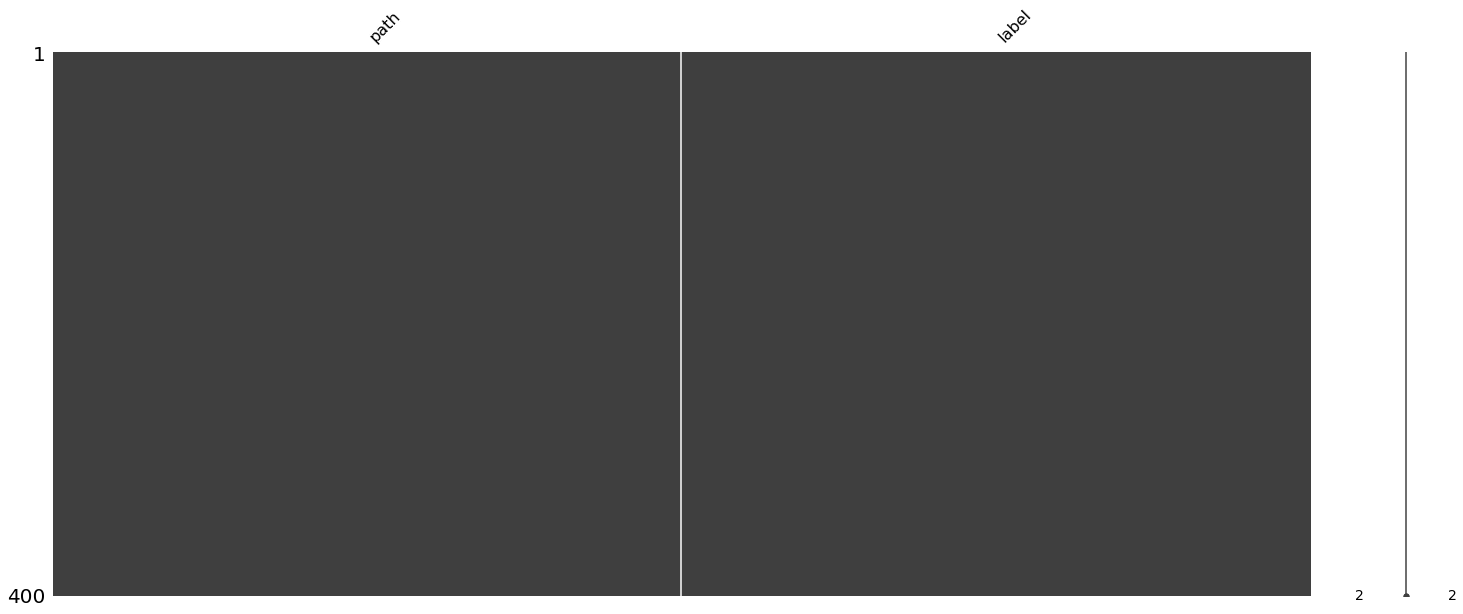

In [16]:
### 1 - Analisando os dados ausentes ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

In [ ]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)

# **Explorando os dados**


# **Type: Data Augumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [ ]:
IMG_SHAPE = 32
BATCH_SIZE = 8

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
# Dados de Treino e Validação

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)


In [ ]:
train_generator = datagen.flow_from_dataframe (data_df,
    batch_size=BATCH_SIZE,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='training')

validation_generator = datagen_val.flow_from_dataframe (data_df,
    batch_size=BATCH_SIZE,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='validation')

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [ ]:
# Dados de Teste

datagen_test = ImageDataGenerator (rescale=1./255, 
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=1,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation') 


 

Found 29998 validated image filenames belonging to 6 classes.


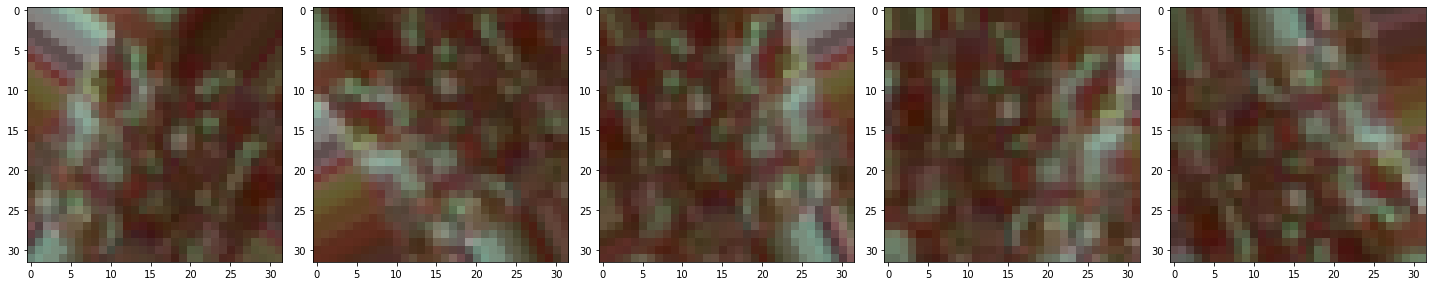

In [ ]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Criando o Dataframe em dados de treino, validação e teste**

In [ ]:
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

train_generator.class_indices.keys()

{'andesite': 0,
 'gneiss': 1,
 'marble': 2,
 'quartzite': 3,
 'rhyolite': 4,
 'schist': 5}

In [ ]:
X_test, y_test = next(test_generator)
print(X_test.shape)
print(y_test.shape)

(24000, 32, 32, 3)
(24000, 6)


# **Criar o modelo**

# ***Parametros***

In [ ]:
INIT_LR = 1e-3
EPOCHS = 100
BS=24

In [ ]:
num_classes = 6

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32,32,3)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
   
])

# **Compilando o Modelo**

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])
model.summary()  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)               

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        #save_weights_only=False,
        #mode='auto',
        #period=1,
    ),

]

# **Avaliar o modelo**

In [ ]:
epochs=200
history = model.fit(X_train,y_train,
                               epochs=EPOCHS,
                               verbose=1,
                               callbacks=callbacks_list,
                               steps_per_epoch = 18000//BS, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_steps = 5999//BS,
                               validation_data= (X_val,y_val))

Epoch 1/200
70/70 [==============================] - 28s 393ms/step - loss: 0.9764 - accuracy: 0.5805 - val_loss: 0.9721 - val_accuracy: 0.5850

Epoch 00001: val_accuracy improved from 0.57750 to 0.58500, saving model to best_model.h5
Epoch 2/200
70/70 [==============================] - 28s 393ms/step - loss: 0.9705 - accuracy: 0.5818 - val_loss: 0.9714 - val_accuracy: 0.5897

Epoch 00002: val_accuracy improved from 0.58500 to 0.58967, saving model to best_model.h5
Epoch 3/200
70/70 [==============================] - 28s 394ms/step - loss: 0.9682 - accuracy: 0.5828 - val_loss: 0.9691 - val_accuracy: 0.5892

Epoch 00003: val_accuracy did not improve from 0.58967
Epoch 4/200
70/70 [==============================] - 28s 396ms/step - loss: 0.9680 - accuracy: 0.5837 - val_loss: 0.9694 - val_accuracy: 0.5878

Epoch 00004: val_accuracy did not improve from 0.58967
Epoch 5/200
70/70 [==============================] - 28s 393ms/step - loss: 0.9655 - accuracy: 0.5853 - val_loss: 0.9633 - val_acc

**Deixe-nos representar graficamente a Precisão do treinamento versus perda para obter uma melhor compreensão do treinamento do modelo.**

Text(0.5, 1.0, 'Train - Accuracy')

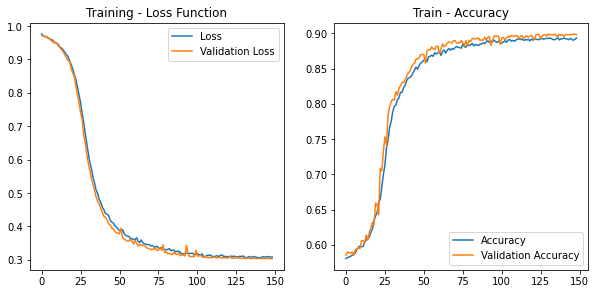

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


# **Vamos traçar a precisão do treinamento e da validação, bem como a perda.** 

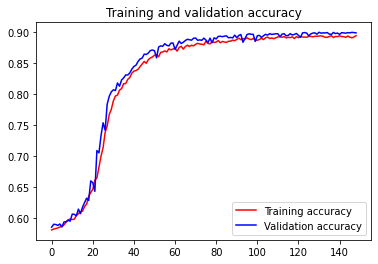

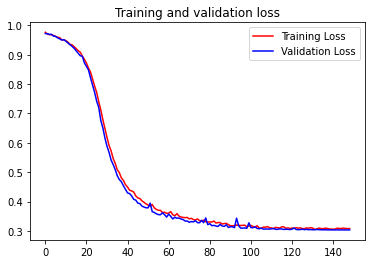

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
history2= model.history.history
px.line(history2,title = "Metrics Plot")

# **Otimizar o modelo**

# **Avaliar acurácia  do Modelo**

In [ ]:
model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc= model.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))

188/188 [==============================] - 3s 14ms/step - loss: 0.3018 - accuracy: 0.8910
validation_accuracy: 0.890999972820282


# **Predição**

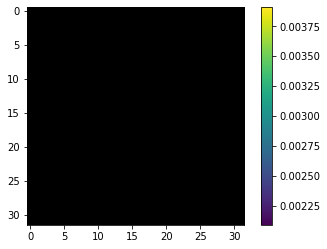

In [ ]:
plt.figure()
plt.imshow(X_train[4])
plt.colorbar()
plt.grid(False)
plt.show()

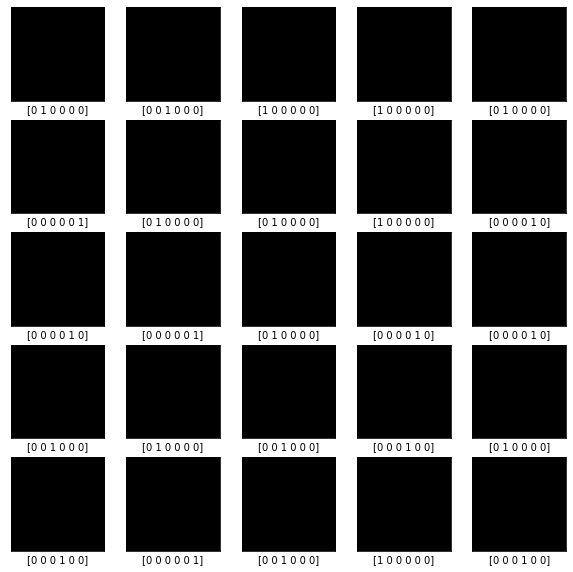

In [ ]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(y_train[i])
plt.show()
   

In [ ]:
pred = model.predict(X_test)
print("Prediction_accuracy: " + str(pred))

Prediction_accuracy: [[4.4237349e-05 5.1119161e-04 9.7813797e-01 3.5523470e-11 5.1980922e-05
  2.1254715e-02]
 [2.5984558e-04 5.4425385e-08 9.7353059e-21 9.9971920e-01 9.2405594e-10
  2.0854950e-05]
 [7.3082192e-06 4.0194062e-03 9.6138841e-01 1.0710959e-11 1.2206150e-05
  3.4572661e-02]
 ...
 [1.3540509e-01 5.9879612e-09 5.4190125e-11 2.9082768e-04 8.6308438e-01
  1.2197671e-03]
 [1.4154476e-05 5.6700963e-01 1.2245647e-07 2.1436308e-05 6.2361799e-08
  4.3295458e-01]
 [7.0211384e-03 1.8503628e-03 1.4095785e-03 9.6701535e-07 6.3408159e-02
  9.2630970e-01]]


In [ ]:
pred[0] # primeira predição

array([4.4237349e-05, 5.1119161e-04, 9.7813797e-01, 3.5523470e-11,
       5.1980922e-05, 2.1254715e-02], dtype=float32)

In [ ]:
np.argmax(pred[0])


2

In [ ]:
y_test [0]

array([0, 0, 1, 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
y_test_predicted = model.predict(X_test)
y_test_predicted

array([[4.4237349e-05, 5.1119161e-04, 9.7813797e-01, 3.5523470e-11,
        5.1980922e-05, 2.1254715e-02],
       [2.5984558e-04, 5.4425385e-08, 9.7353059e-21, 9.9971920e-01,
        9.2405594e-10, 2.0854950e-05],
       [7.3082192e-06, 4.0194062e-03, 9.6138841e-01, 1.0710959e-11,
        1.2206150e-05, 3.4572661e-02],
       ...,
       [1.3540509e-01, 5.9879612e-09, 5.4190125e-11, 2.9082768e-04,
        8.6308438e-01, 1.2197671e-03],
       [1.4154476e-05, 5.6700963e-01, 1.2245647e-07, 2.1436308e-05,
        6.2361799e-08, 4.3295458e-01],
       [7.0211384e-03, 1.8503628e-03, 1.4095785e-03, 9.6701535e-07,
        6.3408159e-02, 9.2630970e-01]], dtype=float32)

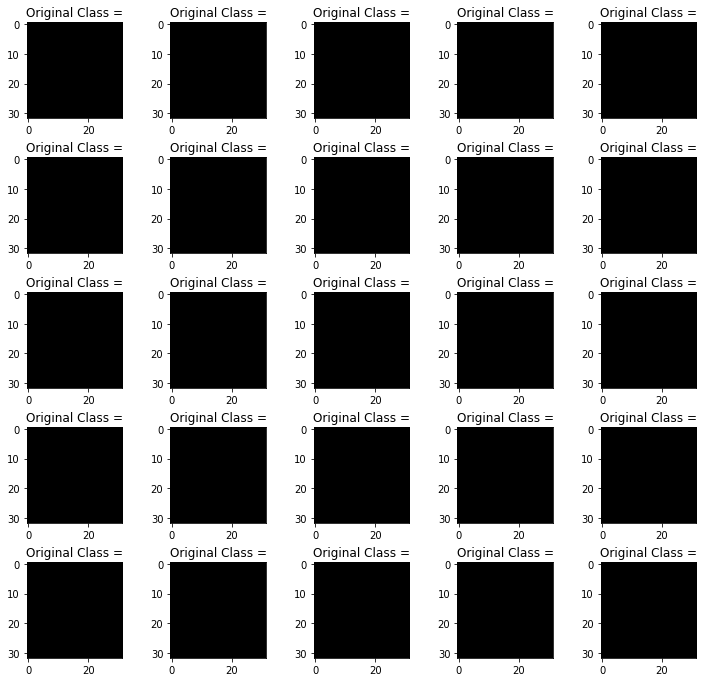

In [ ]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction Class = ") 
    axes[i].set_title("Original Class =" )
plt.subplots_adjust(wspace=0.5)

# **Listando as redes realmente disponíveis em seu Keras**

In [17]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **O Modelo pre treinado VGG16**

In [18]:
# Inicializar a CNN

classifier = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 0s 0us/step


In [26]:
# marcar camadas como não treináveis
for layer in classifier.layers:
    layer.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(32, 32, 3))
#x = datagen (inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
#scale_layer = tf.keras.layers.Rescaling(scale=1 / 255, offset=-1)
#x = scale_layer(inputs)

# adicionar novas camadas para classificação

x = classifier(inputs, training=False)
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = Dense(6, activation='softmax')(x)

#flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
#flat1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
#flat1 = tf.keras.layers.Dropout(0.5)(flat1)
#output = Dense(6, activation='softmax')(flat1)

# definir o modelo
modelvgg16 = Model(inputs=inputs, outputs=output)

modelvgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 14,747,910
Trainable params: 33,222
Non-trainable params: 14,714,688
__________________________________________

In [32]:

modelvgg16.compile(optimizer = Adam(learning_rate=0.0001,decay=INIT_LR / EPOCHS), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]

In [ ]:
historyvgg16 = modelvgg16.fit(X_train,y_train,
                    epochs=EPOCHS,
                    verbose=1,
                    steps_per_epoch = 18000//BS,
                    callbacks=callbacksvgg16,
                    validation_data=(X_val,y_val),
                    validation_steps = 5999//BS)

Epoch 1/200
2250/2250 [==============================] - 317s 141ms/step - loss: 1.7927 - accuracy: 0.1655 - val_loss: 1.7917 - val_accuracy: 0.1647


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f238265c560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f238265c560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 2/200
  32/2250 [..............................] - ETA: 3:44 - loss: 1.7938 - accuracy: 0.1406

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

In [ ]:
modelvgg16 = tf.keras.models.load_model("feature_extraction.vgg16")

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_testVGG16,y_testVGG16)
print("validation_accuracy: " + str(test_accvgg16))

128/128 [==============================] - 40s 312ms/step - loss: 0.2690 - accuracy: 0.8984
validation_accuracy: 0.8984375


# **Comparandos os modelos**

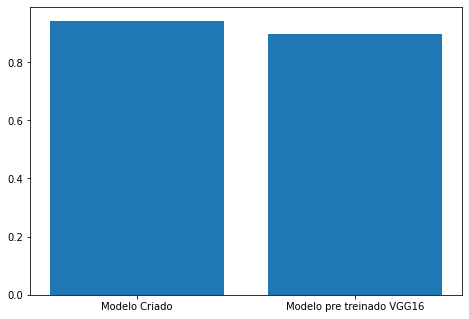

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [test_acc,test_accvgg16]
model = ['Modelo Criado','Modelo pre treinado VGG16']
#model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()

# **Realizar a Predição para as 6 classes**